# Wiener SVD MC closure test using 1mu 1p selection

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
from os import path
import sys

sys.path.append('/exp/sbnd/app/users/munjung/xsec/wienersvd/cafpyana/analysis_village/unfolding')
from wienersvd import *

# import pandas_helpers as ph

# import dunestyle.matplotlib as dunestyle

plt.style.use("presentation.mplstyle")

In [179]:
save_fig = False

In [180]:
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)

In [181]:
def InFV(data): # cm
    xmin = -190.
    ymin = -190.
    zmin = 10.
    xmax = 190.
    ymax =  190.
    zmax =  450.
    return (np.abs(data.x) > 10) & (np.abs(data.x) < 190) & (data.y > ymin) & (data.y < ymax) & (data.z > zmin) & (data.z < zmax)

In [182]:
def get_n_split(file):
    this_split_df = pd.read_hdf(file, key="split")
    this_n_split = this_split_df.n_split.iloc[0]
    return this_n_split

def print_keys(file):
    with pd.HDFStore(file, mode='r') as store:
        keys = store.keys()       # list of all keys in the file
        print("Keys:", keys)

## Opening an MC data frame
This data frame is produced using gump.py configuration

In [183]:
## -- MC study
mc_file = "/data/sungbino/sbnd/v10_06_00_02/mc_MCP2025B_5e18_02_prodgenie_corsika_proton_rockbox_sbnd_CV_caf_flat_caf_sbnd_gump.df"
mc_file = "/exp/sbnd/data/users/munjung/xsec/2025B/MCP_gump_new.df"
mc_split_df = pd.read_hdf(mc_file, key="split")
mc_n_split = get_n_split(mc_file)
print("mc_n_split: %d" %(mc_n_split))
print_keys(mc_file)

mc_n_split: 1
Keys: ['/evt_0', '/hdr_0', '/mcnuwgtslim_0', '/split']


In [184]:
n_max_concat = 2

In [185]:
def load_dfs(file, keys2load):
    out_df_dict = {}
    this_n_keys = get_n_split(file)
    n_concat = min(n_max_concat, this_n_keys)
    for key in keys2load:
        dfs = []  # collect all splits for this key
        for i in range(n_concat):
            this_df = pd.read_hdf(file, key=f"{key}_{i}")
            dfs.append(this_df)
        out_df_dict[key] = pd.concat(dfs, ignore_index=False)

    return out_df_dict

In [9]:
mc_keys2load = ['evt', 'hdr', 'mcnuwgtslim']
mc_dfs = load_dfs(mc_file, mc_keys2load)

In [10]:
mc_evt_df = mc_dfs['evt']
mc_hdr_df = mc_dfs['hdr']
mc_nu_df = mc_dfs['mcnuwgtslim']

In [11]:
## total pot
mc_tot_pot = mc_hdr_df['pot'].sum()
print("mc_tot_pot: %.3e" %(mc_tot_pot))

target_pot = 1e20
mc_pot_scale = target_pot / mc_tot_pot
print("mc_pot_scale: %.3e" %(mc_pot_scale))
mc_pot_scale = 1.

mc_evt_df["pot_weight"] = mc_pot_scale * np.ones(len(mc_evt_df))

mc_tot_pot: 1.504e+18
mc_pot_scale: 6.651e+01


In [284]:
# check available knobs
for col in mc_evt_df.columns:
    if "univ_0" in col:
        print(col)

('Flux', 'univ_0', '', '', '', '', '', '')
('GENIEReWeight_SBN_v1_multisim_ZExpAVariationResponse', 'univ_0', '', '', '', '', '', '')
('GENIEReWeight_SBN_v1_multisim_CCRESVariationResponse', 'univ_0', '', '', '', '', '', '')
('GENIEReWeight_SBN_v1_multisim_NCRESVariationResponse', 'univ_0', '', '', '', '', '', '')
('GENIEReWeight_SBN_v1_multisim_DISBYVariationResponse', 'univ_0', '', '', '', '', '', '')
('GENIEReWeight_SBN_v1_multisim_FSI_pi_VariationResponse', 'univ_0', '', '', '', '', '', '')
('GENIEReWeight_SBN_v1_multisim_FSI_N_VariationResponse', 'univ_0', '', '', '', '', '', '')
('GENIEReWeight_SBN_v1_multisim_NCELVariationResponse', 'univ_0', '', '', '', '', '', '')


## Event Selections

In [249]:
# in FV
print(InFV(mc_evt_df.slc.vertex).value_counts())
mc_evt_df = mc_evt_df[InFV(mc_evt_df.slc.vertex)]

# mu length cut
mc_evt_df = mc_evt_df[mc_evt_df.mu.pfp.trk.len > 50]

# 1p0pi
twoprong_cut = (np.isnan(mc_evt_df.other_shw_length) & np.isnan(mc_evt_df.other_trk_length))
mc_evt_df = mc_evt_df[twoprong_cut]

True    5264
Name: count, dtype: int64


In [250]:
mc_evt_df.loc[:, ("mu","pfp","trk","truth","p","totp","","")] = np.sqrt(mc_evt_df.mu.pfp.trk.truth.p.genp.x**2 + mc_evt_df.mu.pfp.trk.truth.p.genp.y**2 + mc_evt_df.mu.pfp.trk.truth.p.genp.z**2)
mc_nu_df.loc[:, ('mu','totp','')] = np.sqrt(mc_nu_df.mu.genp.x**2 + mc_nu_df.mu.genp.y**2 + mc_nu_df.mu.genp.z**2)

mc_evt_df.loc[:, ("mu","pfp","trk","truth","p","dir","x","")] = mc_evt_df.mu.pfp.trk.truth.p.genp.x/mc_evt_df.mu.pfp.trk.truth.p.totp
mc_evt_df.loc[:, ("mu","pfp","trk","truth","p","dir","y","")] = mc_evt_df.mu.pfp.trk.truth.p.genp.y/mc_evt_df.mu.pfp.trk.truth.p.totp
mc_evt_df.loc[:, ("mu","pfp","trk","truth","p","dir","z","")] = mc_evt_df.mu.pfp.trk.truth.p.genp.z/mc_evt_df.mu.pfp.trk.truth.p.totp

mc_nu_df.loc[:, ("mu","dir","x")] = mc_nu_df.mu.genp.x/mc_nu_df.mu.totp
mc_nu_df.loc[:, ("mu","dir","y")] = mc_nu_df.mu.genp.y/mc_nu_df.mu.totp
mc_nu_df.loc[:, ("mu","dir","z")] = mc_nu_df.mu.genp.z/mc_nu_df.mu.totp

In [251]:
def Signal(df): # definition                                                                                                                                                                                                                                                                         
    is_fv = InFV(df.position)
    is_1mu1p0pi = (df.nmu_27MeV == 1) & (df.npi_30MeV == 0) & (df.np_50MeV == 1) & (df.np_20MeV == 1) & (df.npi0 == 0) & (df.mu.genE > 0.25)
    return is_fv & is_1mu1p0pi

def IsNu(df):
    return ~df.pdg.isna()


def get_int_category(df):
    is_notnu = ~IsNu(df)
    is_nu_outfv = IsNu(df) & ~InFV(df.position)
    is_signal = Signal(df)
    is_other_nu_infv = IsNu(df) & InFV(df.position) & ~Signal(df)

    nuint_categ = pd.Series(8, index=df.index)
    nuint_categ[is_notnu] = -1  # not nu
    nuint_categ[is_nu_outfv] = 0  # nu out of FV
    nuint_categ[is_signal] = 1    # nu in FV, signal
    nuint_categ[is_other_nu_infv] = 2  # nu in FV, not signal

    return nuint_categ

Truth level evt categories

In [252]:
mc_evt_df.loc[:,'nuint_categ'] = get_int_category(mc_evt_df)
mc_nu_df.loc[:,'nuint_categ'] = get_int_category(mc_nu_df)

In [253]:
print(mc_evt_df.nuint_categ.value_counts())
print(mc_nu_df.nuint_categ.value_counts()) # won't have -1 because nudf is all nu events

nuint_categ
 1    1616
-1    1045
 2     749
 0      79
Name: count, dtype: int64
nuint_categ
0    21855
2     7422
1     2368
Name: count, dtype: int64


## Make Spectrum for MC and Fake data

An example binning for muon kinematics -- momentum & dir z

In [254]:
# momentum
var_label = r"$\mathrm{P_\mu~[GeV/c]}$"
var_label_reco = r"$\mathrm{P_\mu^{reco.}~[GeV/c]}$"
var_label_true = r"$\mathrm{P_\mu^{true}~[GeV/c]}$"

bins = np.linspace(0.2, 2, 6)

var_evt_reco_col = ('mu', 'pfp', 'trk', 'P', 'p_muon', '', '', '')
var_evt_truth_col = ('mu', 'pfp', 'trk', 'truth', 'p', 'totp', '', '')
var_nu_col = ('mu', 'totp', '')

# # dir z
# var_label = r"$\mathrm{cos(\theta_\mu)}$"
# var_label_reco = r"$\mathrm{cos(\theta_\mu^{reco.})}$"
# var_label_true = r"$\mathrm{cos(\theta_\mu^{true})}$"

# bins = np.linspace(-1, 1, 6)

# var_evt_reco_col = ('mu', 'pfp', 'trk', 'dir', 'z', '', '', '')
# var_evt_truth_col = ('mu', 'pfp', 'trk', 'truth', 'p', 'dir', 'z', '')
# var_nu_col = ('mu', 'dir', 'z')

Definitions for plotting:
IMPORTANT NOTE: putting signal as the first element for convenience later

In [255]:
mode_list = [1, 2, 0, -1]
mode_labels = ["Signal", "Non-sig. FV Nu", "Non FV Nu", "Not Nu"]
colors = ['#d62728',  # Red            
          '#1f77b4',  # Blue
          '#ff7f0e',
          '#7f7f7f']  # Gray

np.clip is for including underflow events into the first bin and overflow evetns into the last bin

In [256]:
# Total MC reco muon momentum: for fake data
eps = 1e-8
var_total_mc = mc_evt_df[var_evt_reco_col]
var_total_mc = np.clip(var_total_mc, bins[0], bins[-1] - eps)

# mc_evt_df divided into mode for subtraction from data in futre
# first item in list is the signal
mc_evt_df_divided = [mc_evt_df[mc_evt_df.nuint_categ == mode]for mode in mode_list]

# Reco muon momentum for each 'nuint_categ' for stack plot and subtraction from the fake data
var_per_nuint_categ_mc = [mc_evt_df[mc_evt_df.nuint_categ == mode][var_evt_reco_col]for mode in mode_list]
var_per_nuint_categ_mc = [s.clip(bins[0], bins[-1] - eps) for s in var_per_nuint_categ_mc]
weights_per_categ = [mc_evt_df.loc[mc_evt_df.nuint_categ == mode, 'pot_weight'] for mode in mode_list]

# for response matrix
# Signal event's reco muon momentum after the event selection
var_signal = mc_evt_df[mc_evt_df.nuint_categ == 1][var_evt_reco_col]
var_signal = np.clip(var_signal, bins[0], bins[-1] - eps)
weight_signal = mc_evt_df.loc[mc_evt_df.nuint_categ == 1, 'pot_weight']

# Signal event's true muon momentum after the event selection
true_var_signal_sel = mc_evt_df[mc_evt_df.nuint_categ == 1][var_evt_truth_col]
true_var_signal_sel = np.clip(true_var_signal_sel, bins[0], bins[-1] - eps)
weight_true_signal = mc_evt_df.loc[mc_evt_df.nuint_categ == 1, 'pot_weight']

# for efficiency vector
# Signal event's true muon momentum without event selection
var_truth_signal = mc_nu_df[mc_nu_df.nuint_categ == 1][var_nu_col]
var_truth_signal = np.clip(var_truth_signal, bins[0], bins[-1] - eps)
weight_truth_signal = np.full_like(var_truth_signal, mc_pot_scale, dtype=float)

Draw true (before event selection) and reco (after event selection) muon momentum distributions of signal events.
Print entries for double check.

[1179.  750.  282.   83.   74.]
[755. 524. 205.  79.  53.]
[739. 516. 231.  76.  54.]


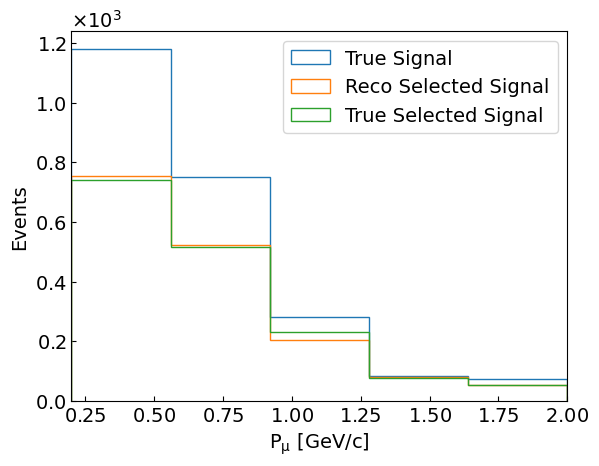

In [257]:
true_signal, _, _ = plt.hist(var_truth_signal, bins=bins, weights=weight_truth_signal, histtype="step", label="True Signal")
reco_signal_sel, _, _ = plt.hist(var_signal, bins=bins, weights=weight_signal, histtype="step", label="Reco Selected Signal")
true_signal_sel, _, _ = plt.hist(true_var_signal_sel, bins=bins, weights=weight_signal, histtype="step", label="True Selected Signal")
print(true_signal)
print(reco_signal_sel)
print(true_signal_sel)
plt.legend()
plt.ylabel("Events")
plt.xlim(bins[0], bins[-1])
plt.xlabel(var_label)
plt.show()

## Overlayed spectrum

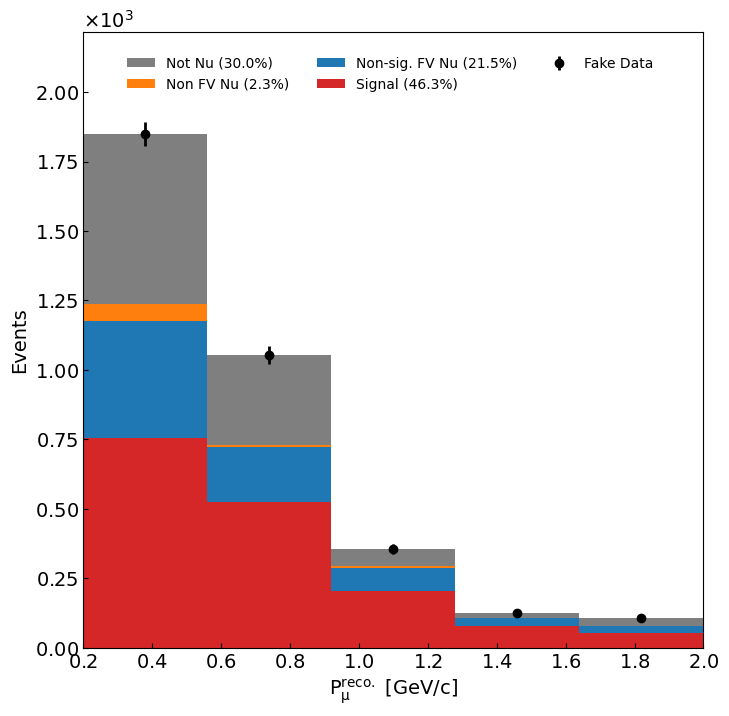

In [258]:
plt.figure(figsize=(8, 8))
mc_stack, bins, _ = plt.hist(var_per_nuint_categ_mc,
                            bins=bins,
                            weights=weights_per_categ,
                            stacked=True,
                            color=colors,
                            label=mode_labels,
                            edgecolor='none',
                            linewidth=0,
                            density=False,
                            histtype='stepfilled')

totmc, bin_edges = np.histogram(var_total_mc, bins=bins, weights=mc_evt_df.pot_weight)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# use MC as fake data for closure test
fake_data = totmc
fake_data_err = np.sqrt(totmc)
# plt.step(bin_edges[:-1], fake_data, where='post', label="Data")  # line
plt.errorbar(bin_centers, fake_data, yerr=fake_data_err, fmt='o', color='black')  # error bars

accum_sum = [np.sum(data) for data in mc_stack]
accum_sum = [0.] + accum_sum
total_sum = accum_sum[-1]
individual_sums = [accum_sum[i + 1] - accum_sum[i] for i in range(len(accum_sum) - 1)]
fractions = [(count / total_sum) * 100 for count in individual_sums]
legend_labels = [f"{label} ({frac:.1f}%)" for label, frac in zip(mode_labels[::-1], fractions[::-1])]
legend_labels.append("Fake Data")
plt.legend(legend_labels, loc='upper left', fontsize=10, frameon=False, ncol=3, bbox_to_anchor=(0.05, 0.98))

plt.xlim(bins[0], bins[-1])
plt.xlabel(var_label_reco)
plt.ylim(0., 1.2 * fake_data.max())
plt.ylabel("Events")

plt.show()

# Response

In [259]:
## A function is to make text in 2D plots more visible
def get_text_color(value):
    rgba = cmap(norm(value))
    # Compute luminance (perceived brightness)
    luminance = 0.299 * rgba[0] + 0.587 * rgba[1] + 0.114 * rgba[2]
    return "black" if luminance > 0.5 else "white"

def bin_range_labels(edges):
    return [f"{edges[i]:.2f}–{edges[i+1]:.2f}" for i in range(len(edges)-1)]

For selected signal, true vs. reco. muon momentum

[[678.  58.   1.   2.   0.]
 [ 46. 408.  52.   7.   3.]
 [ 22.  47. 131.  24.   7.]
 [  7.   7.  14.  36.  12.]
 [  2.   4.   7.  10.  31.]]


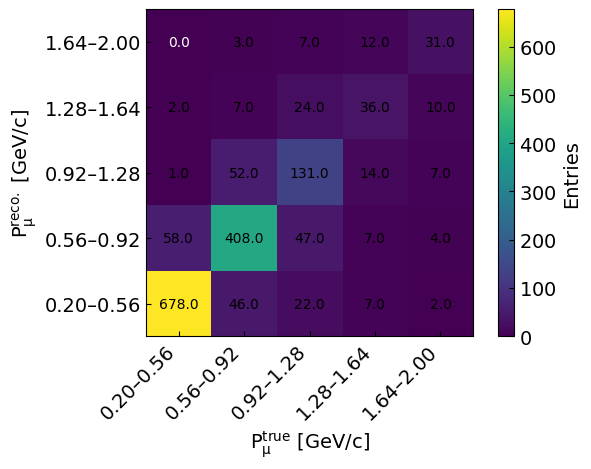

In [260]:
bins_2d = bins# = [np.array([0.2, 2]), np.array([0.2, 2])] # commented out lines for 1 bin MC closure test
reco_vs_true, bins, _ = np.histogram2d(true_var_signal_sel, var_signal, bins=bins_2d)
Response = reco_vs_true.T
print(reco_vs_true)

unif_bin = np.linspace(0., float(len(bins) - 1), len(bins))
extent = [unif_bin[0], unif_bin[-1], unif_bin[0], unif_bin[-1]]
plt.imshow(Response, extent=extent, origin="lower", cmap="viridis")
plt.colorbar(label="Entries")

x_edges = np.array(bins)
y_edges = np.array(bins)
x_tick_positions = (unif_bin[:-1] + unif_bin[1:]) / 2
y_tick_positions = (unif_bin[:-1] + unif_bin[1:]) / 2

x_labels = bin_range_labels(x_edges)
y_labels = bin_range_labels(y_edges)

plt.xticks(x_tick_positions, x_labels, rotation=45, ha="right")
plt.yticks(y_tick_positions, y_labels)

plt.xlabel(var_label_true)
plt.ylabel(var_label_reco)

for i in range(Response.shape[0]):      # rows (y)
    for j in range(Response.shape[1]):  # columns (x)
        value = Response[i, j]
        if not np.isnan(value):  # skip NaNs
            plt.text(
                j + 0.5, i + 0.5,
                f"{value:.1f}",
                ha="center", va="center",
                color=get_text_color(value),
                fontsize=10
            )

plt.tight_layout()
plt.show()

Effieincy vector

In [261]:
reco_vs_true.T.sum(axis=0)

array([739., 516., 231.,  76.,  54.])

In [262]:
true_signal

array([1179.,  750.,  282.,   83.,   74.])

In [263]:
eff = reco_vs_true.T.sum(axis=0) / true_signal  # efficiency per truth bin
print("eff")
print(eff)

eff
[0.62680237 0.688      0.81914894 0.91566265 0.72972973]


Response matrix for Wiener SVD is actually Response X Eff.

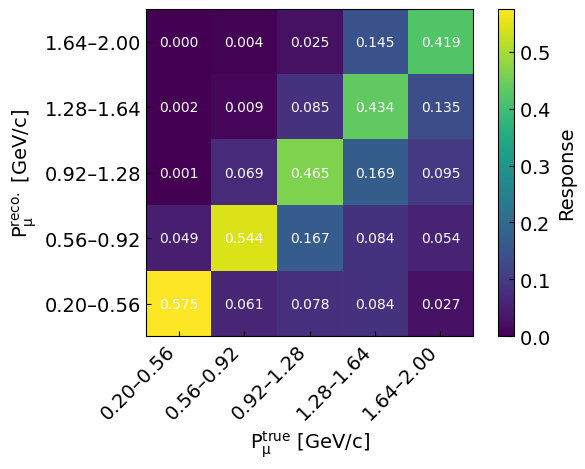

In [264]:
denom = reco_vs_true.T.sum(axis=0)
num = reco_vs_true.T
Response = np.divide(
    num * eff, denom,
    out=np.zeros_like(num, dtype=float),  # fill with 0 where invalid
    where=denom != 0
)

unif_bin = np.linspace(0., float(len(bins) - 1), len(bins))
extent = [unif_bin[0], unif_bin[-1], unif_bin[0], unif_bin[-1]]
plt.imshow(Response, extent=extent, origin="lower", cmap="viridis")
plt.colorbar(label="Response")

x_edges = np.array(bins)
y_edges = np.array(bins)
x_tick_positions = (unif_bin[:-1] + unif_bin[1:]) / 2
y_tick_positions = (unif_bin[:-1] + unif_bin[1:]) / 2

x_labels = bin_range_labels(x_edges)
y_labels = bin_range_labels(y_edges)

plt.xticks(x_tick_positions, x_labels, rotation=45, ha="right")
plt.yticks(y_tick_positions, y_labels)

plt.xlabel(var_label_true)
plt.ylabel(var_label_reco)

for i in range(Response.shape[0]):      # rows (y)
    for j in range(Response.shape[1]):  # columns (x)
        value = Response[i, j]
        if not np.isnan(value):  # skip NaNs
            plt.text(
                j + 0.5, i + 0.5,
                f"{value:.3f}",
                ha="center", va="center",
                color=get_text_color(value),
                fontsize=10
            )

plt.tight_layout()
plt.show()

# Covariance

Considered multiverses

## Flux

Produce "Fake data - bkg" distributions in multiverses

In [265]:
var_total_mc
fake_data, bins, _ = plt.hist(var_total_mc, bins=bins,histtype="step", color="gray")
plt.close()
fake_data

array([1848., 1053.,  356.,  126.,  106.])

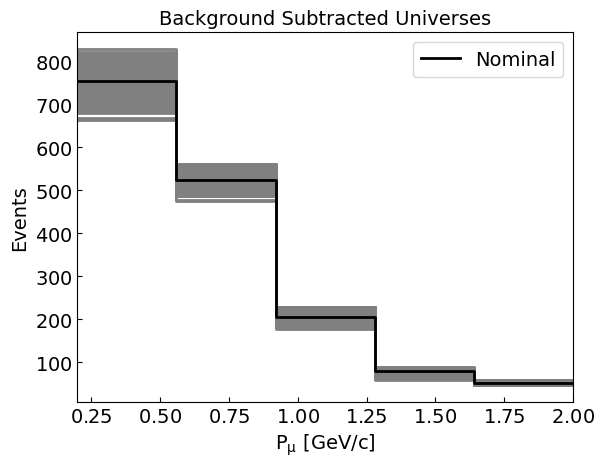

In [276]:
bin_centers = (bins[:-1] + bins[1:])/2
univ_events = []

nominal_event = fake_data
for this_mc_evt_df in mc_evt_df_divided[1:]:  # first item is the signal
    this_var = this_mc_evt_df[var_evt_reco_col]
    this_var = np.clip(this_var, bins[0], bins[-1] - eps)
    this_n, bins, _ = plt.hist(this_var, bins=bins, histtype="step", color="gray")
    nominal_event = nominal_event - this_n

univ = 1000
for uidx in range(univ):
    this_signal = fake_data # before subtraction
    for this_mc_evt_df in mc_evt_df_divided[1:]: # first item is the signal
        weights = this_mc_evt_df["Flux"]["univ_{}".format(uidx)].copy()
        weights[np.isnan(weights)] = 1 ## IMPORTANT: make nan weights to 1. to ignore them
        this_var = this_mc_evt_df[var_evt_reco_col]
        this_var = np.clip(this_var, bins[0], bins[-1] - eps)
        this_n, bins, _ = plt.hist(this_var, bins=bins, weights=weights, histtype="step", color="gray")
        plt.close()
        this_signal = this_signal - this_n # a subtracted hitogram for a multiverse
    univ_events.append(this_signal)

for univ_event in univ_events:
    plt.step(bin_edges, np.append(univ_event, univ_event[-1]), where='post', color="gray")
    plt.xlim(bins[0], bins[-1])
    plt.xlabel(var_label)
    plt.ylabel("Events")

plt.step(bin_edges, np.append(nominal_event, nominal_event[-1]), where='post', color="black", label="Nominal")

plt.title("Background Subtracted Universes")
plt.legend()
plt.show()

Make covariance matrix out of the above distributions

[[706.58251509 336.72878337 175.78688334  72.81394667  38.90851991]
 [336.72878337 184.3223243  105.03604542  47.97022069  23.68887488]
 [175.78688334 105.03604542  68.19362474  32.60891541  16.31070018]
 [ 72.81394667  47.97022069  32.60891541  18.40481527   8.11147469]
 [ 38.90851991  23.68887488  16.31070018   8.11147469   4.75569217]]


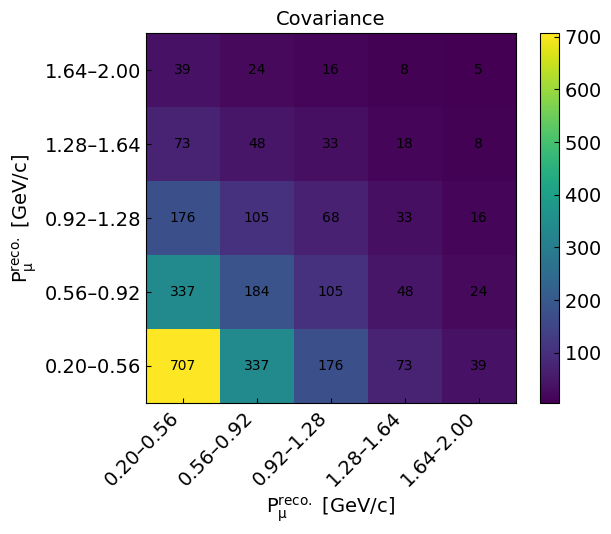

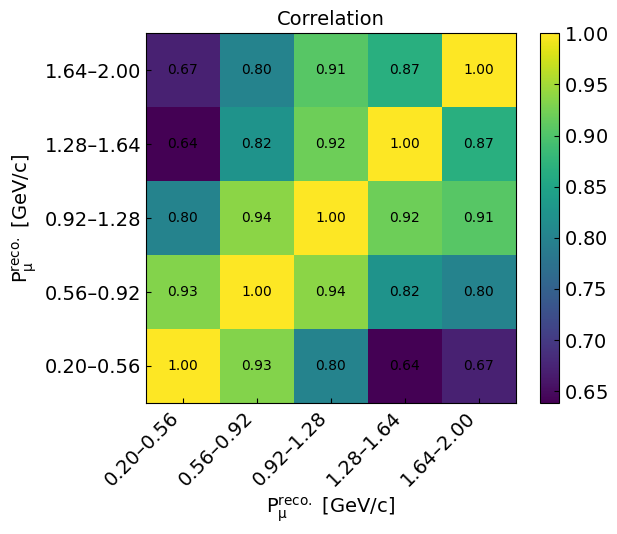

In [267]:
univ_events = np.array(univ_events)
Covariance = np.cov(univ_events, rowvar=False)
Covariance = np.atleast_2d(Covariance)
print(Covariance)
plt.imshow(Covariance, extent=extent, origin="lower")
plt.colorbar()
plt.xticks(x_tick_positions, x_labels, rotation=45, ha="right")
plt.yticks(y_tick_positions, y_labels)
plt.xlabel(var_label_reco)
plt.ylabel(var_label_reco)
for i in range(Covariance.shape[0]):      # rows (y)
    for j in range(Covariance.shape[1]):  # columns (x)
        value = Covariance[i, j]
        if not np.isnan(value):  # skip NaNs
            plt.text(
                j + 0.5, i + 0.5,
                f"{value:.0f}",
                ha="center", va="center",
                color=get_text_color(value),
                fontsize=10
            )
plt.title("Covariance")
if save_fig:
    plt.savefig("./plots/wiener_svd/1mu1p/cov.pdf")
plt.show();

corr = np.corrcoef(univ_events.T)
corr = np.atleast_2d(corr)
plt.imshow(corr, extent=extent, origin="lower")
plt.colorbar()
plt.xticks(x_tick_positions, x_labels, rotation=45, ha="right")
plt.yticks(y_tick_positions, y_labels)
plt.xlabel(var_label_reco)
plt.ylabel(var_label_reco)
for i in range(corr.shape[0]):      # rows (y)
    for j in range(corr.shape[1]):  # columns (x)
        value = corr[i, j]
        if not np.isnan(value):  # skip NaNs
            plt.text(
                j + 0.5, i + 0.5,
                f"{value:.2f}",
                ha="center", va="center",
                color=get_text_color(value),
                fontsize=10
            )
plt.title("Correlation")
plt.show();

Singal distribution with error bars from diagonal components of covariance matrix

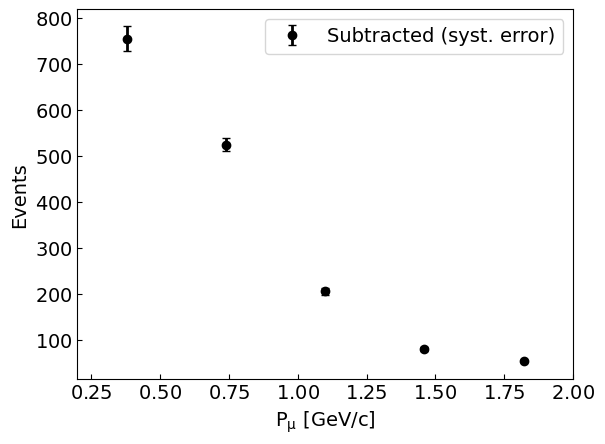

In [268]:
uncert = np.sqrt(np.diag(Covariance))

# Compute bin centers for error bars
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Add error bars
plt.errorbar(bin_centers, nominal_event, yerr=uncert, fmt='o', color='black', label='Subtracted (syst. error)', capsize=3)
plt.xlim(bins[0], bins[-1])
plt.xlabel(var_label)
plt.ylabel("Events")
plt.legend()
plt.show()

# Try Unfolding

In [269]:
nominal_event

array([755., 524., 205.,  79.,  53.])

In [270]:
true_signal

array([1179.,  750.,  282.,   83.,   74.])

In [271]:
C_type = 0
Norm_type = 1
unfold = WienerSVD(Response, true_signal, nominal_event, Covariance, C_type, Norm_type)

In [272]:
unfold['unfold']

array([1173.77505338,  748.28259482,  281.32097949,   82.75285231,
         73.91486294])

In [273]:
unfold['UnfoldCov']

array([[1804.41755681,  646.06514377,  418.95416223,  126.47951232,
          66.58706105],
       [ 646.06514377,  285.0697436 ,  194.61807986,   78.29782889,
          25.43400995],
       [ 418.95416223,  194.61807986,  171.34704497,   66.01072985,
          26.10278323],
       [ 126.47951232,   78.29782889,   66.01072985,   50.62484593,
           4.06848942],
       [  66.58706105,   25.43400995,   26.10278323,    4.06848942,
          10.45113528]])

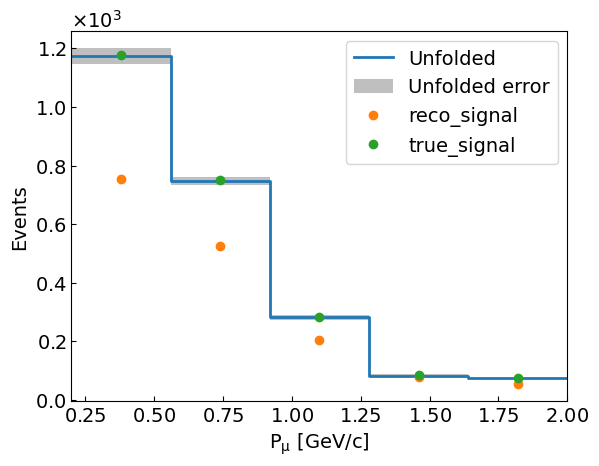

In [277]:
Unfold = unfold['unfold']
UnfoldCov = unfold['UnfoldCov']
Unfold_uncert = np.sqrt(np.diag(Covariance))

step_handle, = plt.step(bin_edges, np.append(Unfold, Unfold[-1]), where='post', label='Unfolded')
bar_handle = plt.bar(
    bin_centers,
    2*Unfold_uncert,
    width=(bin_edges[1] - bin_edges[0]) * 1.,
    bottom=Unfold - Unfold_uncert,
    color='gray',
    alpha=0.5,
    linewidth=0,
    label='Unfolded Stat. error (box)'
)
reco_handle, = plt.plot(bin_centers, reco_signal_sel, 'o', label='reco_signal')
true_handle, = plt.plot(bin_centers, true_signal, 'o', label='true_signal')

# Custom order for legend
handles = [step_handle, bar_handle, reco_handle, true_handle]
labels = [
    'Unfolded',
    'Unfolded error',
    'reco_signal',
    'true_signal'
]

plt.legend(handles, labels)
plt.xlim(bins[0], bins[-1])
plt.xlabel(var_label)
# plt.ylim(0., 5000.)
plt.ylabel("Events")
plt.show()